In [1]:
# import statements including namaster python wrapper
import numpy as np
import healpy as hp
import os
import pymaster as nmt
import pysm3
import pysm3.units as u
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import warnings
warnings.filterwarnings("ignore")

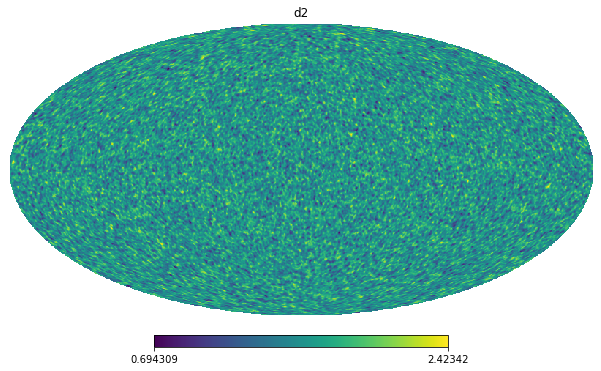

In [2]:
map_std0p2 = hp.read_map("beta_mean1p59_std0p2.fits")
hp.mollview(map_std0p2, title = 'd2')

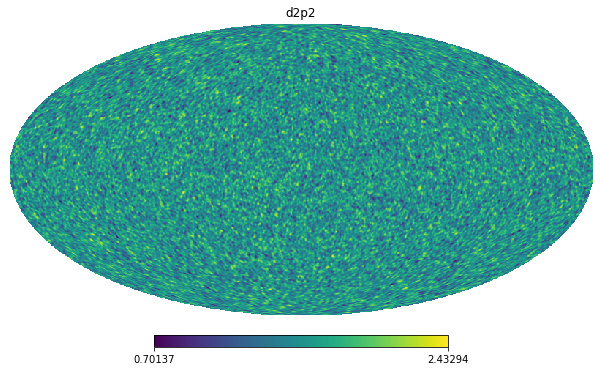

In [3]:
rand512=np.random.randn(3145728)
d2p2_fwhm = hp.sphtfunc.smoothing(rand512,fwhm=0.01745)
d2p2 = d2p2_fwhm*(0.2/np.std(d2p2_fwhm))+1.59
hp.mollview(d2p2, title = 'd2p2')

In [4]:
hp.fitsfunc.write_map("beta_mean1p59_std0p2_2.fits",d2p2)

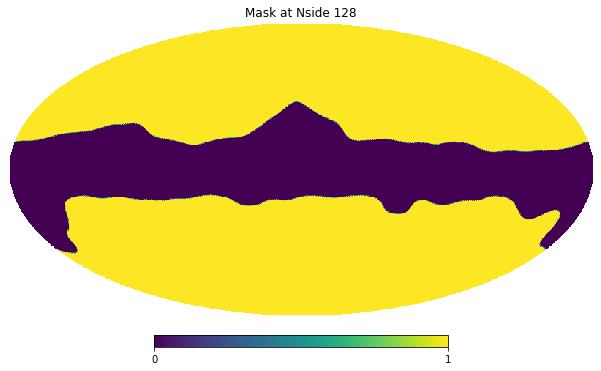

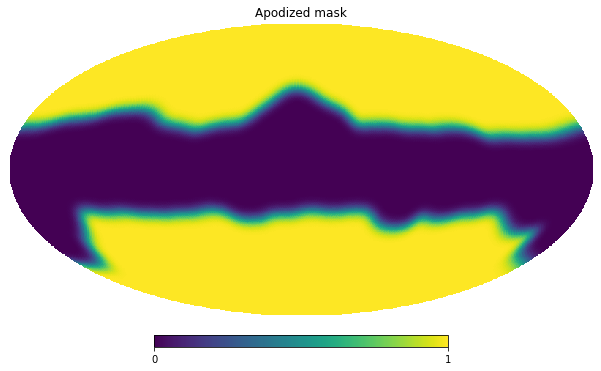

In [6]:
# read in a planck mask, lower resolution, and apodize it on a scale of ~3 degrees
# HEALPix resolution parameter
nside = 128
# initialize binning scheme with 12 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 12)
# read planck mask (GAL070) and lower resolution to nside=128
mask = hp.read_map("HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=3)
mask_128 = hp.pixelfunc.ud_grade(mask, 128)
hp.mollview(mask_128, title='Mask at Nside 128')
# save mask
# hp.write_map("mask_GAL070_128.fits", mask_128)
# read mask and apodize it on a scale of ~3degs
mask = nmt.mask_apodization(hp.read_map("mask_GAL070_128.fits", verbose=False), 3., apotype="Smooth")
hp.mollview(mask, title='Apodized mask')

In [7]:
# functions that take in a map, the map_217, the cl1x1 value, and the map 217 field and outputs r80 value for BB, EE, or TT
def rbb80(map_nu2, clbb1x1, f2_map_nu1, mask):
    # initialize spin-2 field for map2
    f2_map_nu2 = nmt.NmtField(mask, map_nu2, purify_b = True)
    clbb1x2 = nmt.compute_full_master(f2_map_nu1, f2_map_nu2, b)[3][6]
    clbb2x2 = nmt.compute_full_master(f2_map_nu2, f2_map_nu2, b)[3][6]
    return clbb1x2/(np.sqrt(clbb1x1*clbb2x2))
def ree80(map_nu2, clee1x1, f2_map_nu1, mask):
    # initialize spin-2 field for map2
    f2_map_nu2 = nmt.NmtField(mask, map_nu2, purify_e = True)
    clee1x2 = nmt.compute_full_master(f2_map_nu1, f2_map_nu2, b)[0][6]
    clee2x2 = nmt.compute_full_master(f2_map_nu2, f2_map_nu2, b)[0][6]
    return clee1x2/(np.sqrt(clee1x1*clee2x2))
def rtt80(map_nu2, cltt1x1, f0_map_nu1, mask):
    # initialize spin-0 field for map2
    f0_map_nu2 = nmt.NmtField(mask, [map_nu2])
    cltt1x2 = nmt.compute_full_master(f0_map_nu1, f0_map_nu2, b)[0][6]
    cltt2x2 = nmt.compute_full_master(f0_map_nu2, f0_map_nu2, b)[0][6]
    return cltt1x2/(np.sqrt(cltt1x1*cltt2x2))  

In [8]:
freqs = np.arange(150,3000,150)
rbb80_vals_d2 = np.ones((len(freqs)))*1.
ree80_vals_d2 = np.ones((len(freqs)))*1.
rtt80_vals_d2 = np.ones((len(freqs)))*1.
rbb80_vals_d2p2 = np.ones((len(freqs)))*1.
ree80_vals_d2p2 = np.ones((len(freqs)))*1.
rtt80_vals_d2p2 = np.ones((len(freqs)))*1.
# HEALPix resolution parameter
nside = 128
# initialize binning scheme with 10 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 12)

# for d2
# make a sky
sky_d2 = pysm3.Sky(nside=128, preset_strings=["d2"])
os.environ["PYSM_LOCAL_DATA"] = os.getcwd()
sky_d2p2 = pysm3.Sky(nside=128, component_config="d2p2.cfg")
# make 217GHz map
map_217GHz_d2 = sky_d2.get_emission(217 * u.GHz)
map_217GHz_d2p2 = sky_d2p2.get_emission(217 * u.GHz)

# for d2, initialize a spin-2 field for BB & EE and a spin-0 field for TT, compute their cl80 values
f2_map_nu1_bb_d2 = nmt.NmtField(mask, map_217GHz_d2[1:,:], purify_b = True)
clbb1x1_d2 = nmt.compute_full_master(f2_map_nu1_bb_d2, f2_map_nu1_bb_d2, b)[3][6]
f2_map_nu1_ee_d2 = nmt.NmtField(mask, map_217GHz_d2[1:,:], purify_e = True)
clee1x1_d2 = nmt.compute_full_master(f2_map_nu1_ee_d2, f2_map_nu1_ee_d2, b)[0][6]
f0_map_nu1_d2 = nmt.NmtField(mask, [map_217GHz_d2[0]])
cltt1x1_d2 = nmt.compute_full_master(f0_map_nu1_d2, f0_map_nu1_d2, b)[0][6]

# for d2p2, initialize a spin-2 field for BB & EE and a spin-0 field for TT, compute their cl80 values
f2_map_nu1_bb_d2p2 = nmt.NmtField(mask, map_217GHz_d2p2[1:,:], purify_b = True)
clbb1x1_d2p2 = nmt.compute_full_master(f2_map_nu1_bb_d2p2, f2_map_nu1_bb_d2p2, b)[3][6]
f2_map_nu1_ee_d2p2 = nmt.NmtField(mask, map_217GHz_d2p2[1:,:], purify_e = True)
clee1x1_d2p2 = nmt.compute_full_master(f2_map_nu1_ee_d2p2, f2_map_nu1_ee_d2p2, b)[0][6]
f0_map_nu1_d2p2 = nmt.NmtField(mask, [map_217GHz_d2p2[0]])
cltt1x1_d2p2 = nmt.compute_full_master(f0_map_nu1_d2p2, f0_map_nu1_d2p2, b)[0][6]

# compute Rl[80] for every 150GHz from 150GHz to 3THz
for j, freq in enumerate(freqs):
    map_freq_d2 = sky_d2.get_emission(freq * u.GHz)
    map_freq_d2p2 = sky_d2p2.get_emission(freq * u.GHz)
    rbb80_vals_d2[j] = (1 - rbb80(map_freq_d2[1:,:], clbb1x1_d2, f2_map_nu1_bb_d2, mask))
    ree80_vals_d2[j] = (1 - ree80(map_freq_d2[1:,:], clee1x1_d2, f2_map_nu1_ee_d2, mask))
    rtt80_vals_d2[j] = (1 - rtt80(map_freq_d2[0,:], cltt1x1_d2, f0_map_nu1_d2, mask))
    rbb80_vals_d2p2[j] = (1 - rbb80(map_freq_d2p2[1:,:], clbb1x1_d2p2, f2_map_nu1_bb_d2p2, mask))
    ree80_vals_d2p2[j] = (1 - ree80(map_freq_d2p2[1:,:], clee1x1_d2p2, f2_map_nu1_ee_d2p2, mask))
    rtt80_vals_d2p2[j] = (1 - rtt80(map_freq_d2p2[0,:], cltt1x1_d2p2, f0_map_nu1_d2p2, mask))

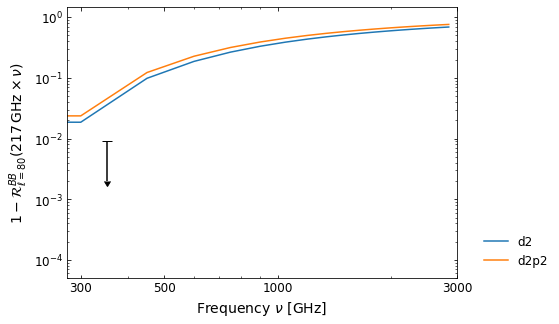

In [9]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{BB}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)

ax.plot(freqs, rbb80_vals_d2, label= 'd2')
ax.plot(freqs, rbb80_vals_d2p2, label= 'd2p2')

ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

#plt.savefig('all_models_217_bb3.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

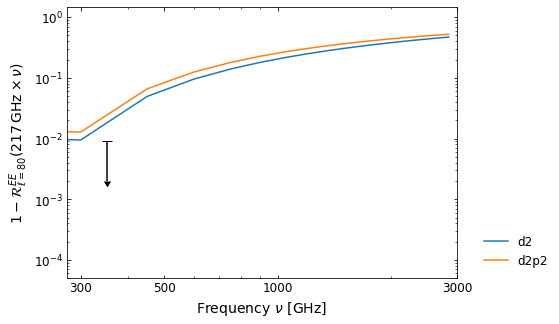

In [10]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{EE}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)

ax.plot(freqs, ree80_vals_d2, label= 'd2')
ax.plot(freqs, ree80_vals_d2p2, label= 'd2p2')

ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

#plt.savefig('all_models_217_ee3.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

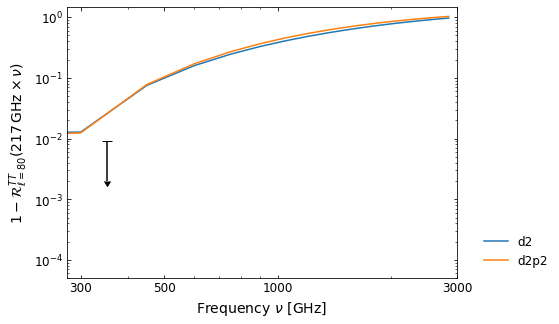

In [11]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{TT}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)

ax.plot(freqs, rtt80_vals_d2, label= 'd2')
ax.plot(freqs, rtt80_vals_d2p2, label= 'd2p2')

ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

#plt.savefig('all_models_217_tt3.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')